To Run in Colab, Uncomment the following three code cells

In [1]:
#!git clone https://github.com/satyajeetprabhu/djembedancedata-internship.git

In [2]:
#cd /content/djembedancedata-internship

In [3]:
#import os
#os.makedirs('export', exist_ok=True)

### Import

In [4]:
import detrending_functions as dtr
import matplotlib.pyplot as plt

%matplotlib inline

### File Paths

In [5]:
meter_path = 'data/djembedancedata_example/BKO_E1_D1_02_Maraka_C_Marker in sec.csv'
D1_path = 'data/djembedancedata_example/BKO_E1_D1_02_Maraka_P-Dun_vamp_bbc-vamp-plugins_bbc-rhythm_onset.csv'
J1_path = 'data/djembedancedata_example/BKO_E1_D1_02_Maraka_P-Jem-1_vamp_bbc-vamp-plugins_bbc-rhythm_onset.csv'
J2_path = 'data/djembedancedata_example/BKO_E1_D1_02_Maraka_P-Jem-2_vamp_bbc-vamp-plugins_bbc-rhythm_onset.csv'

### Load Onset annotations

In [6]:
onsets_df = dtr.load_df_csv([D1_path, J1_path, J2_path], delimiter=';', concat_axis=1, header=None)

# Add header to the dataframe
onsets_df.columns = ['D1', 'J1', 'J2']
onsets_df.head(10)

,D1,J1,J2
0,8.551000,5.881667,10.951000
1,10.073667,6.143000,11.161667
2,10.484333,6.335000,11.569667
3,10.889667,6.428333,11.785667
4,11.127000,6.543000,12.207000
5,11.583000,6.633667,12.420333
6,12.009667,6.793667,12.844333
7,12.668333,7.012333,13.068333
8,13.068333,7.220333,13.497667
9,13.481667,7.452333,13.735000


### Load Meter annotations

In [7]:
meter_df = dtr.load_df_csv(meter_path, delimiter=';')
meter_df.columns = ['Keyboard.Time']
meter_df.head()

,Keyboard.Time
0,11.129
1,13.706
2,16.260
3,18.728
4,21.223


### Select subdivisions, window shape (tolerance)

In [8]:
num_div = 12
tolerance = (0.5, 0.5) # Proportion of subdivision on either side of the downbeat

## Detrending

### Level 2 : Intermediate "instrument anchor" (level 2 m.cycle) 

['downbeats to onsets' eq.]
1. Closest instrument (mixed) [choose closest onset to lev1, either instr1 or
instr2]
2. defined.instr.rules [take window, show preference for defined.instr, e.g.
If there is an instr1 stroke in the window select it, else go for the instr2]


#### Mode 2.1 : Instrument Anchor - Closest Instrument

In [9]:
defined_instr = ['J2'] 

mode = 'closest.instr'

In [10]:
meter_df = dtr.detrend_anchor(meter_df, 
                           time_column='Keyboard.Time', 
                           instr_df=onsets_df[defined_instr], 
                           tolerance=tolerance, 
                           num_div=num_div, 
                           mode='closest.instr',
                           col_name='Anchor.Time.1')

Use help() for detailed notes on function parameters

In [11]:
#help(dtr.detrend_anchor)

In [12]:
meter_df.head()

,Keyboard.Time,Anchor.Time.1
0,11.129,11.161667
1,13.706,13.735000
2,16.260,16.255000
3,18.728,18.753667
4,21.223,21.244333


### Mode 2.2 : Instrument Anchor - defined.instr.rules

For this mode, order of preference is assumed in the list. For example in the list below, preference : D1 > J1 > J2

In [13]:
defined_instr = ['D1', 'J1', 'J2']

mode = 'defined.instr'

In [14]:
meter_df = dtr.detrend_anchor(meter_df, 
                           time_column='Keyboard.Time', 
                           instr_df=onsets_df[defined_instr], 
                           tolerance=tolerance, 
                           num_div=num_div, 
                           mode='defined.instr',
                           col_name='Anchor.Time.2')

In [15]:
meter_df.tail()

,Keyboard.Time,Anchor.Time.1,Anchor.Time.2
203,331.530,331.524333,331.529667
204,332.748,332.756333,332.767000
205,333.981,333.993667,334.009667
206,335.231,335.247000,335.233667
207,336.578,336.580333,336.580333


## Plot Onsets in Cycles

#### 1. Assign Onsets to Cycle Subdivisions

[Equivalent to onsets_to_metrical_grid() in carat]  
  
Here, we construct a new dataframe assigning onsets to subdivisions. Currently, this function uses a naive approach of dividing a cycle duration into isochronous subdivisions and assigning an onset to the closest subdivision. Its purpose is to plot a general distribution onsets in a cycle to visualise the effects of detrending which is the primary focus of this notebook.

First let's start by using 'Keyboard Time' as reference for cycle start times

In [16]:
df1 = dtr.assign_onsets_to_cycles(onsets_df=onsets_df, cycle_time=meter_df['Keyboard.Time'], tolerance=tolerance, num_div=num_div)

#help(dtr.assign_onsets_to_cycles)

#### 2. Plot  

[Equivalent to onsets_in_grid_plot() in carat]

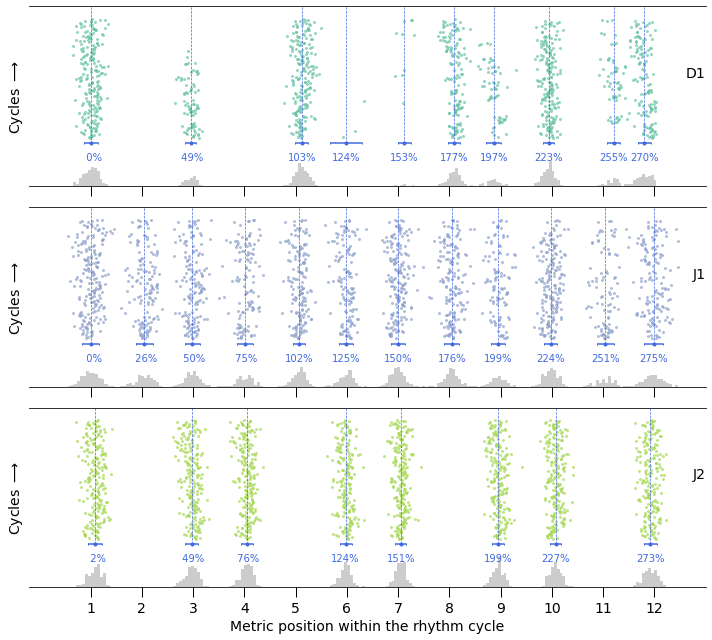

In [17]:
fig1 = dtr.plot_cycle_onsets(df1, instr=['D1','J1', 'J2'], mean_std=True, hist_ons=True)

#help(dtr.plot_cycle_onsets)

## Comparison

##### Using Anchor.Time.1 as Cycle Time

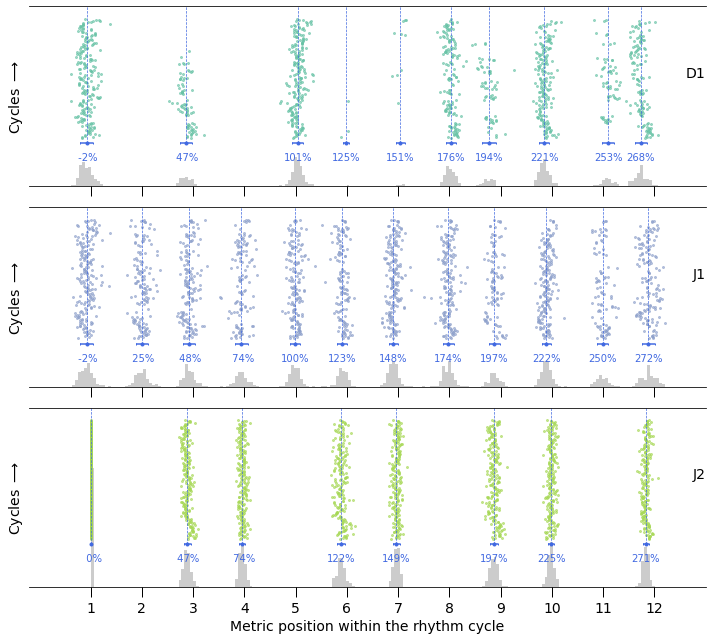

In [18]:
# Assign
df2 = dtr.assign_onsets_to_cycles(onsets_df, cycle_time=meter_df['Anchor.Time.1'], tolerance=tolerance, num_div=num_div)
# Plot
fig2 = dtr.plot_cycle_onsets(df2, instr=['D1','J1', 'J2'], mean_std=True, hist_ons=True)

##### Using Anchor.Time.2 as Cycle Time

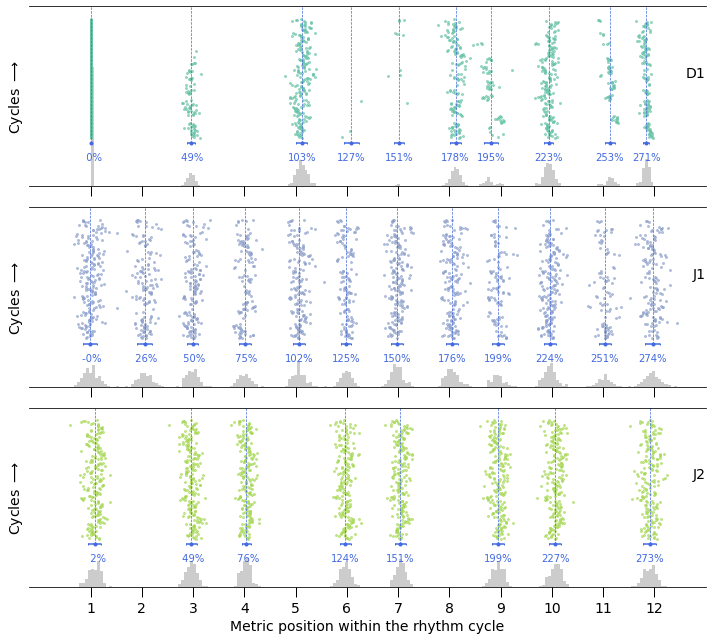

In [19]:
# Assign
df3 = dtr.assign_onsets_to_cycles(onsets_df, cycle_time=meter_df['Anchor.Time.2'], tolerance=tolerance, num_div=num_div)
# Plot
fig3 = dtr.plot_cycle_onsets(df3, instr=['D1','J1', 'J2'], mean_std=True, hist_ons=True)

## Level 3 : Virtual Time

This is a single general purpose function that provides 3 modes of computing new cycle start times from the onsets falling inside a window.  
  
- mode = 'median' : median of onsets in window.  
- mode = 'simple.mean': mean of onsets in window.  
- mode = 'mean.of.avg': average of onsets in window by instrument, followed by mean of averages.  
  
Accordingly, by selecting the appropriate reference time (level1 or level2), new level 3 times can be computed.

For example, let us construct level 3 virtual times by taking a simple mean of D1 and J2 onsets within window around the Keyboard (level 1) time.

In [20]:
defined_instr = ['D1','J2']

In [21]:
meter_df = dtr.detrend_virtual(meter_df, 
                           time_column='Keyboard.Time', 
                           instr_df=onsets_df[defined_instr], 
                           tolerance=tolerance, 
                           num_div=num_div, 
                           mode='simple.mean',
                           col_name='Democratic.Time.1')

#help(dtr.detrend_virtual)

In [22]:
meter_df.tail()

,Keyboard.Time,Anchor.Time.1,Anchor.Time.2,Democratic.Time.1
203,331.530,331.524333,331.529667,331.527000
204,332.748,332.756333,332.767000,332.761667
205,333.981,333.993667,334.009667,334.001667
206,335.231,335.247000,335.233667,335.240333
207,336.578,336.580333,336.580333,336.580333


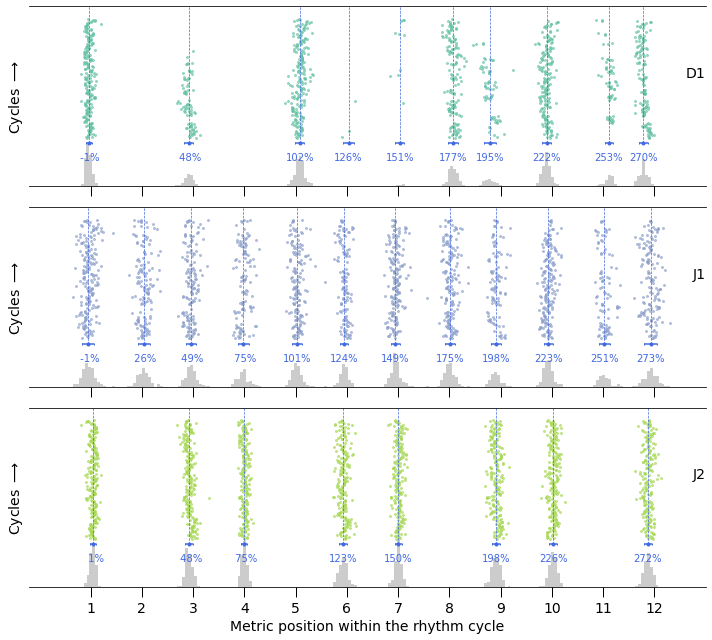

In [23]:
# Assign
df4 = dtr.assign_onsets_to_cycles(onsets_df, cycle_time=meter_df['Democratic.Time.1'], tolerance=tolerance, num_div=num_div)
# Plot
fig4 = dtr.plot_cycle_onsets(df4, instr=['D1','J1', 'J2'], mean_std=True, hist_ons=True)

## Overall Onset Distribution Plot

This function can be used to plot an overall distribution of onsets irrespective of instrument. Choose the dataframe and instruments to plot.

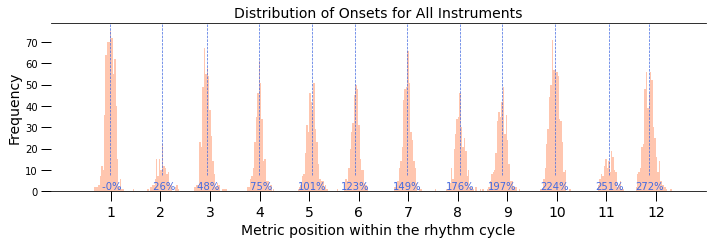

In [28]:
fig4_hist = dtr.plot_cycle_hist(df=df4, instr=['D1','J1','J2'], mean_std=True, bins=400)

#help(dtr.plot_cycle_hist)

## Export

In [25]:
# Choose the dataframe to export and set filename
df_export = df4  
filename_df = 'df_4.csv'

# Uncomment the following line to export the dataframe to a csv file
#df_export.to_csv(f'export/{filename_df}')

In [26]:
# Choose the figure to export and set filename
fig_export = fig4
filename_fig = 'fig_4.png'

# Uncomment the following line to save the figure
#fig_export.savefig(f'export/{filename_fig}')